In [83]:
from sklearn.model_selection import train_test_split
import sqlite3
import numpy as np
import keras
from keras.utils import to_categorical
import pandas as pd
from PIL import Image
import io
import pickle

def load_dataset(database_path):
     # Connect to the SQLite database
    conn = sqlite3.connect(database_path)

    # Query to select all records from the faces table
    query = "SELECT * FROM faces"

    # Fetch records from the database into a Pandas DataFrame
    df = pd.read_sql_query(query, conn)
    df['image'] = df['image'].apply(lambda x: np.array(pickle.loads(x)))
    # Close the database connection
    conn.close()
    # Convert image bytes to numpy array
    num_classes = len(np.unique(df['target']))
    return df, num_classes

In [84]:
def split_dataset(df, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(df['image'].values, df['target'].values, test_size=test_size, random_state=random_state)
    # Convert the image arrays to a numpy array
    X_train = np.array([np.array(img) for img in X_train])
    X_test = np.array([np.array(img) for img in X_test])
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Print the shapes of the resulting sets
    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    # Plot the first image in X_train
    plt.imshow(X_train[0])
    plt.title('First Image in X_train')
    plt.show()

    return X_train, X_test, y_train, y_test

In [85]:

def preprocess_and_print_shapes(y_train, y_test):
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    return y_train_categorical, y_test_categorical

In [86]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
    return model


In [87]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Resizing
from keras.applications import vgg16
def train_model_v2(num_classes, X_train, y_train, X_test, y_test):
    
    vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in vgg.layers:
        layer.trainable = False


    model = Sequential()
    model.add(Resizing(224, 224))
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
    return model


In [88]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Check if y_test is one-hot encoded and convert it back to class labels
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy1 = accuracy_score(y_test, predicted_classes)
    print("Accuracy:", accuracy1)

    # Precision
    precision = precision_score(y_test, predicted_classes, average='weighted')
    print("Precision:", precision)

    # Recall
    recall = recall_score(y_test, predicted_classes, average='weighted')
    print("Recall:", recall)

    # F1 Score
    f1 = f1_score(y_test, predicted_classes, average='weighted')
    print("F1 Score:", f1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    # Sum the values for TP, TN, FP, FN
    TP = np.sum(np.diag(cm))
    TN = np.sum(np.delete(np.delete(cm, np.arange(len(cm)), axis=0), np.arange(len(cm)), axis=1))
    FP = np.sum(cm, axis=0) - np.diag(cm)
    FN = np.sum(cm, axis=1) - np.diag(cm)

    # Print the results
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", np.sum(FP))
    print("False Negatives (FN):", np.sum(FN))
    return accuracy1, precision, recall, f1

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(df, model, X_test, y_test, num_rows=5, num_cols=5, figsize=(20, 20)):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.ravel()

    # Loop through the test set and visualize predictions
    for i in range(num_rows * num_cols):
        
        actual_name = df['name'][np.where(df['target'].values == np.argmax(y_test, axis=1)[i])[0][0]]
        predicted_name = df['name'][np.where(df['target'].values == predicted_classes[i])[0][0]] 

        axes[i].imshow(X_test[i])
        axes[i].set_title("Prediction Class = {}\nTrue Class = {}".format(predicted_name, actual_name))
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training set shape: (7, 62, 47, 3) (7,)
Testing set shape: (2, 62, 47, 3) (2,)


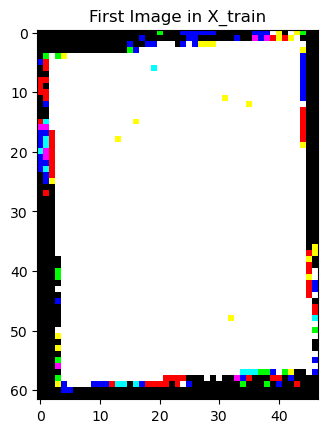

IndexError: index 10 is out of bounds for axis 1 with size 9

In [90]:
df, num_classes = load_dataset('lfw_dataset.db')
X_train, X_test, y_train, y_test = split_dataset(df)

y_train, y_test = preprocess_and_print_shapes(y_train, y_test)

input_shape = (62, 47, 3)

# Train the model
cnn_model = train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test)

#Evaluate the model
accuracy1, precision, recall, f1 = evaluate_model(cnn_model, X_test, y_test)
print("Accuracy:", accuracy1)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save the trained model
cnn_model.save('trained_model.h5')

#visualize the model on test set
visualize_predictions(df, cnn_model, X_test, y_test)

In [ ]:
from numpy import expand_dims

def visualize_feature_maps(model, image):
    
    #Get indices of convolutional layers
    conv_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, Conv2D)]

    #Create a list to store convolutional layers
    conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]

    #Create a new model containing only the convolutional layers
    model2 = Model(inputs=model.inputs, outputs=[layer.output for layer in conv_layers])

    #Expand the dimensions of the input to match the model's expected input shape
    image = expand_dims(image, axis=0)

    #Get the feature maps
    feature_maps = model2.predict(image)
    summed_feature_maps = [fmap_list.sum(axis=-1) for fmap_list in feature_maps]

    #Plot the feature maps
    fig = plt.figure(figsize=(15, 15))
    layer_index = 0

    for summed_fmap in summed_feature_maps:
        ax = plt.subplot(len(conv_layers), 1, layer_index + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(summed_fmap[0, :, :], cmap='gray')

        layer_index += 1

    plt.show()
    
visualize_feature_maps(cnn_model, X_train[0])

NameError: name 'Model' is not defined